<h1>Local setup with Anaconda</h1>
<p>You will need the following packages:<p>
<ol>
    <li><b>networkx:</b> <code>conda install networkx</code></li><br>
    <li><b>hiveplot:</b> <code>conda install -c conda-forge hiveplot</code></li><br>
    <li><b>nxviz:</b> <code>conda install -c conda-forge nxviz</code></li><br>
    <li><a href="https://github.com/taynaud/python-louvain"><b>python-louvain:</b></a><code>conda install python-louvain</code></li><br>
    <li><a href="https://jiffyclub.github.io/palettable/"><b>palettable:</b></a><code>conda install palettable</code></li>
<ol>

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm

import networkx as nx
from nxviz import MatrixPlot, ArcPlot, CircosPlot
from hiveplot import HivePlot
import community 
import palettable as pal


%matplotlib inline

<h1>Loading datasets</h1>
<p>There are different file formats for storing network data and in most cases these data are divided into two files: one file contains edges and their attributes while the other contains nodes and their attributes.<br>
When loading the dataset, you have to decide which class of graphs to use based on the network structure you want to represent.
</p>
<p>
NetworkX provides the following classes:
<ul>
<li> Graph: undirected graphs with self loops </li>
<li> DiGraph: directed graphs with self loops </li>
<li> MultiGraph: undirected graphs with self loops and parallel edges </li>
<li> MultiDiGraph: directed graphs with self loops and parallel edges </li>
<li> OrderedGraphs: consistently ordered graphs </li>
</ul>
</p>

In [86]:
def load_seventh_graders():
    # Read the edge list
    df = pd.read_csv('data/seventh/out.moreno_seventh_seventh', skiprows=2, header=None, sep=' ')
    df.columns = ['student1', 'student2', 'count']

    # Read the node metadata
    nodeAttributes = pd.read_csv('data/seventh/ent.moreno_seventh_seventh.student.gender',header=None)
    nodeAttributes.index += 1
    nodeAttributes.columns = ['gender']
    
    # Construct graph from edge list.
    G = nx.DiGraph()
    for row in df.iterrows():
        G.add_edge(row[1]['student1'], row[1]['student2'], count=row[1]['count'])
    
    # Add node attributes
    for n in G.nodes():
        (G.nodes[n])['gender'] = nodeAttributes.iloc[n-2]['gender']
    
    return G

def load_windsurfer():
    df = pd.read_csv('data/beach/out.moreno_beach_beach', skiprows=2, header=None, sep=' ')
    df.columns = ['surf1', 'surf2','weight']
    G = nx.from_pandas_edgelist(df, source='surf1', target='surf2',edge_attr='weight')
    
    return G

def load_trainingbomb():
    df = pd.read_csv('data/bombing/out.moreno_train_train', skiprows=2, header=None, sep=' ')
    df.columns = ['terrorist1', 'terrorist2','weight']
    G = nx.from_pandas_edgelist(df, source='terrorist1', target='terrorist2',edge_attr='weight')
    
    return G

def load_facebook():
    df = pd.read_csv('data/facebook/out.ego-facebook', skiprows=2, header=None, sep=' ')
    df.columns = ['user1', 'user2']
    G = nx.from_pandas_edgelist(df, source='user1', target='user2')
    
    return G

<a href="http://konect.uni-koblenz.de/networks/moreno_seventh"><h2>Seventh graders dataset</h2></a>
<p>This directed network contains proximity ratings between students from 29 seventh grade students from a school in Victoria. Among other questions the students were asked to nominate their preferred classmates for three different activities. A node represents a student. An edge between two nodes shows that the left student picked the right student as his answer. The edge weights are between 1 and 3 and show how often the left student chose the right student as his favourite.</p>

In [87]:
G = load_seventh_graders()
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 29
Number of edges: 376
Average in degree:  12.9655
Average out degree:  12.9655


<h3>Basic operations</h3>
<p>In the networkx implementation, graph objects store their data in dictionaries.</p>
<p>Graph.nodes -> {ID : dictionary of attributes}</p>
<p>Graph.edges -> {(ID1,ID2) : dictionary of attributes}</p>

In [88]:
#The G.nodes() returns an object of type Nodedataview
#we can cast it to a list in order to perform list-slicing and extract subsets of the graph.
#The optional parameter data lets you see nodes metadata.
list(G.nodes(data=True))[:3]

[(1, {'gender': 'female'}), (2, {'gender': 'male'}), (3, {'gender': 'male'})]

In [89]:
#count the number of nodes
len(G.nodes())

29

In [90]:
list(G.edges(data=True))[:3]

[(1, 2, {'count': 1}), (1, 3, {'count': 1}), (1, 4, {'count': 2})]

In [91]:
#access an attribute of a single node
G.nodes[1]['gender']

'female'

<p>General useful patterns are:
<ul>
    <li><code>[n2 for n1, n2, d in G.edges(data=True)]</code></li><br>
    <li><code>[d['attr'] for n, d in G.nodes(data=True)]</code></li>
</ul>
</p>

In [92]:
#wer can see how many students have "unrequited" friendships
len([(n1, n2) for n1, n2 in G.edges() if not G.has_edge(n2, n1)])

124

<h1>Graph visualization</h1>

<p>The most important thing regarding the traditional visualization of a graph is to assign the coordinates to each node. <br>
To obtain more pleasant visualizations, libraries such as NetworkX provide methods of graph layouts.
Some layout types are independent of connectivity patterns (random, circular, spiral, shell).
Other layouts, on the other hand, perform optimization algorithms of some measure and are called force-directed layouts (kamada-kawai, spring, spectral).</p>
<p>If the network is large, visualizations begin to look like <b>hairballs</b> and you can not get any useful information about its features. <br> So there are other ways to visualize networks following a <b>rational visualization approach</b>: arc plots, circus plots and hive plots. <br> The principle behind <b>rational visualization</b> is to prioritize the placement of nodes in a certain way and then look at the edges and how they are structured according to the organization of the nodes.</p>

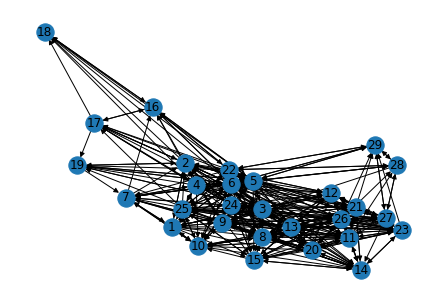

In [93]:
#hairballs
nx.draw(G, with_labels=True)

In [94]:
#We define here a function that will serve us throughout this presentation.
#This function allows you to draw a graph by coloring the nodes according to the value of a measurement.
def draw_measure(G, pos, title, node_size, cmap, measure, show=False, scale_color=True, color_bar=True):

    if measure: 
        nodes =  nx.draw_networkx_nodes(G, pos, node_size=node_size, cmap=cmap, 
                                   node_color=list(map(float,measure.values())),
                                   nodelist=list(map(float,measure.keys())))
    else:
        nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size)
                
    if scale_color:
        nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
        
    edges = nx.draw_networkx_edges(G, pos, edge_color= "gray", width=.5)

    plt.title(title)
    if color_bar:
        plt.colorbar(nodes)
    plt.axis('off')
    
    if show:
        plt.show()

<a href="http://konect.uni-koblenz.de/networks/moreno_train"><h2>Train bombing dataset</h2></a>
<p>This undirected network contains contacts between suspected terrorists involved in the train bombing of Madrid on March 11, 2004 as reconstructed from newspapers. A node represents a terrorist and an edge between two terrorists shows that there was a contact between the two terroists. The edge weights denote how 'strong' a connection was. This includes friendship and co-participating in training camps or previous attacks.</p>

In [95]:
G = load_trainingbomb()
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<p>In this case we use <b>python-louvain</b> for undirected graphs (which tries to maximize the modularity of the network
). The algorithm divides the nodes into groups and then we add this information to each node.</p>

<Figure size 432x288 with 0 Axes>

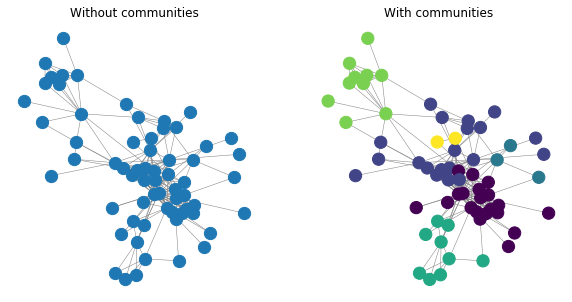

In [96]:
pos = nx.spring_layout(G)

plt.figure()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

draw_measure(G, pos, 'Without communities', 150, None, None,
                                    show=False, scale_color=False, color_bar=False)

plt.subplot(1, 2, 2)

#louvain algorithm
partition = community.best_partition(G)
for n in G.nodes():
    G.nodes[n]['group'] =  partition[n]

draw_measure(G, pos, 'With communities', 150, plt.cm.viridis, dict(G.nodes.data(data='group')),
                                                 show=True, scale_color=False, color_bar=False)

<h2>Arc plot</h2>
<p>In arc diagrams, nodes are displayed along a single axis and links are represented with arcs.<br>Nodes can be grouped or ordered by a criteria in order to visualize the <b>density</b> of the connections between groups.</p>

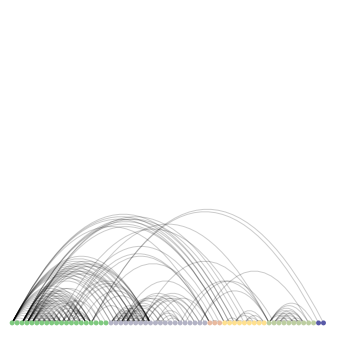

In [97]:
a = ArcPlot(G, node_color='group', node_grouping='group', node_labels=True)
a.draw()

<h2>Circos plot</h2>
<p>This visualization helps us highlight nodes that there are <b>poorly connected</b>, and others that are <b>strongly connected</b>.</p>

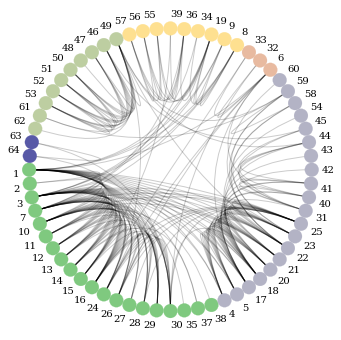

In [98]:
c = CircosPlot(G, node_color='group', node_grouping='group', node_labels=True)
c.draw()

<h2>Hiveplots</h2>
<p>Hive plots allow us to divide our nodes into sub-groups, and visualize the within- and between-group connectivity.</p>

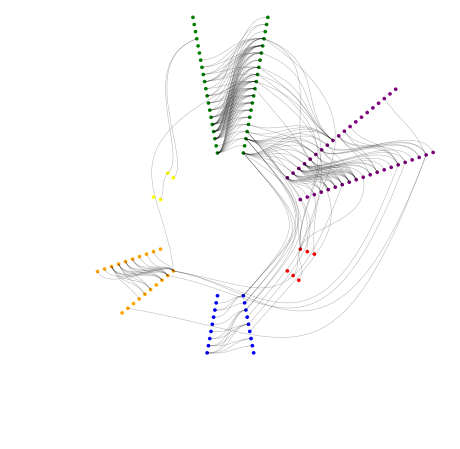

In [99]:
colors=['green','purple','red','blue','orange','yellow']
groups=list(pd.Series(partition).unique())

nodes = dict()
nodes_cmap = dict()
for i in groups:
    nodes[i] = [n for n,d in G.nodes(data=True) if d['group'] == i]
    nodes_cmap[i] = colors[i]

edges = dict()
edges['group1'] = G.edges(data=True)

edges_cmap = dict()
edges_cmap['group1'] = 'black'

h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<p>We can get a better visualization using only three groups for example, we could choose the three groups that have more edges than the others.</p>

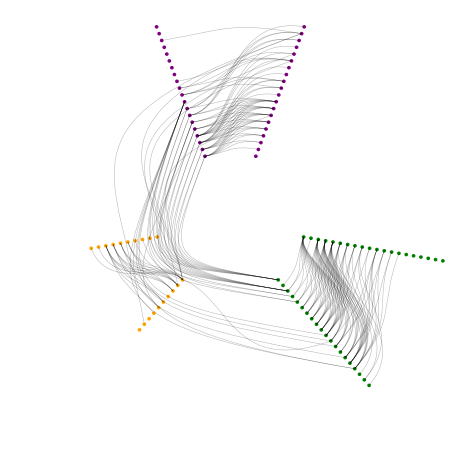

In [100]:
groups=list(pd.Series(partition).value_counts()[:3].index)
nodes = dict()
nodes_cmap = dict()
for i in groups:
    nodes[i] = [n for n,d in G.nodes(data=True) if d['group'] == i]
    nodes_cmap[i] = colors[i]

edges = dict()
edges['group1'] = G.subgraph([n for n in G.nodes() if (G.nodes()[n]['group'] in groups)]).edges(data=True)

h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<h2>Adjacency matrix</h2>

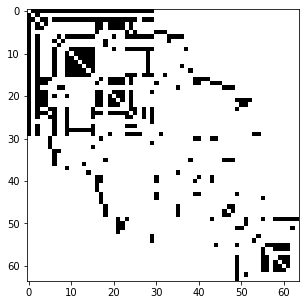

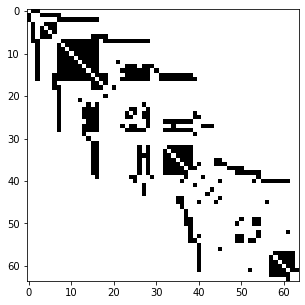

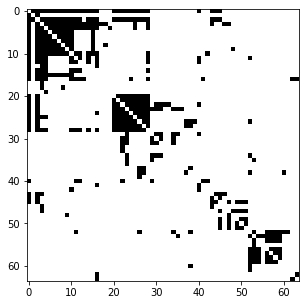

In [105]:
from networkx.utils import cuthill_mckee_ordering
from matplotlib import patches

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    fig = plt.figure(figsize=(5,5))
    plt.imshow(adjacency_matrix, cmap="Greys", interpolation="none")

rcm = list(cuthill_mckee_ordering(G))

from collections import defaultdict
# Convert community assignmet dict into list of communities
louvain_comms = defaultdict(list)
for node_index, comm_id in partition.items():
    louvain_comms[comm_id].append(node_index)
louvain_comms = louvain_comms.values()

nodes_louvain_ordered = [node for comm in louvain_comms for node in comm]

draw_adjacency_matrix(G)
draw_adjacency_matrix(G, node_order=rcm)
draw_adjacency_matrix(G, nodes_louvain_ordered, [louvain_comms], ["blue"])

<h1>Centrality measures</h1>

<p>
    <a href="https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html">Centrality measures</a> identify the most important vertices within a graph.<br>
    The word "important" has different interpretations and in fact there are different measures of centrality.<br>
    <ul>
        <li><b>Degree centrality:</b> is the number of nearest neighbours (local measurement). 
In practice, a node with a high Degree centrality indicates that it has direct contact with many other nodes.</li>
        <li><b>Closeness centrality:</b> is the average length of the shortest path between the node and all other nodes in the graph. It indicates how close a node is to all other nodes in the network. 
In practice, a node with a high Closeness centrality indicates that to communicate with the other nodes it needs on average fewer steps than those with a low Closeness centrality (short communication path with others).</li>
        <li><b>Eigenvector centrality: </b> a recursive definition of this measure is that the importance of a node depends on the importance of its neighbors. Nodes with high eigenvector centrality tends to be grouped in the same cluster.
</li>
        <li><b>Betweenness centrality: </b> is the number of shortest paths going through the node. In practise a node with high Betweenness centrality acts as a bridge along the shortest path between two other nodes (information flow, spread of a virus).</li>
    </ul>
</p>  
<p>
    There are also centrality measures related to the whole graph called <b>Centralizations</b>. They indicate how central is the node which has the highest value of a certain measure of centrality in relation to the other nodes. These measures are used to compare the centrality between graphs.</p>
<p>When talking about direct graphs, the measurements seen above refer to the outgoing edges and are slightly different to take into account the direction of the edges.<br>
   Looking at the incoming edges we can define the measure of <b>prestige</b> of a node which is similar to the eigenvector centrality in the sense that the prestige of a node depends on the prestige of the nodes that point it. This measure cannot always be calculated (cycles, source nodes ...). <br>    
Over time, ranking measures of nodes have been introduced, especially to the work done in the web search. 
    For example, <b><a href="https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html">PageRank</a></b> simulates a user's behavior based on random walks to assign each node a rank based on the probability that it has to be visited. The page rank is similar to the node's in-degree but it also depends on the page rank of the in-degree nodes.</p>
<p>
    The <b><a href="https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.link_analysis.hits_alg.hits.html">hub and authority algorithm (HITS)</a></b> introduces two other metrics for a node that allows you to differentiate the role of each node within the graph (information aggregator vs information creator). As part of a network of citations, for example, an authority score and a hub score can be assigned to a paper. A paper with an high authority score is a paper that is  is cited in good review papers. A paper with a high hub score is a node that cites good papers (Good authorities referred by good hubs and good hubs point to good authorities)</p>

<p>We can use a Circoplot to understand which terrorists have the most direct contact with other terrorists. To facilitate understanding, the nodes can be colored based on the value of the Degree centrality.</p>

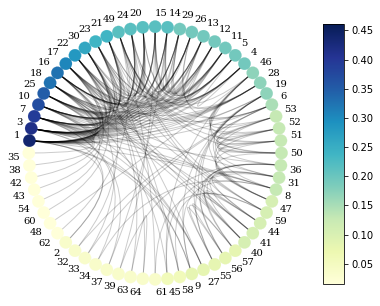

In [70]:
centr = {k: v for k, v in  nx.degree_centrality(G).items()}
for n in centr:
    G.nodes[n]['centrality'] =  centr[n]
c = CircosPlot(G, node_color='centrality', node_grouping='centrality', node_labels=True)
c.draw()

<p>Since the graph is not too large, we can visualize it in the standard way and show how the various centrality measures perform.</p>

<Figure size 432x288 with 0 Axes>

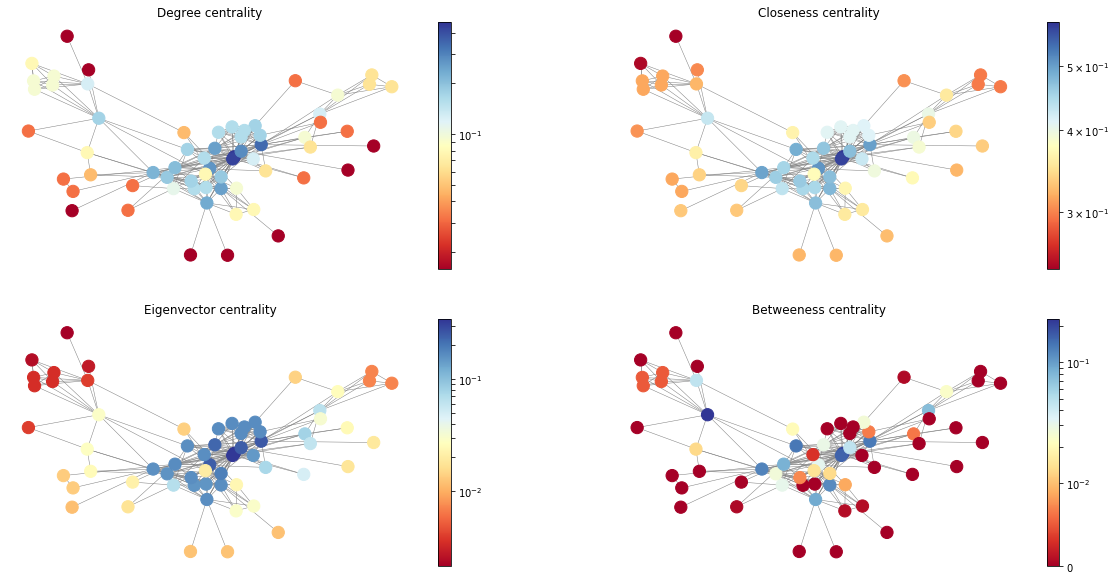

In [71]:
pos = nx.spring_layout(G)
cmap = pal.colorbrewer.diverging.RdYlBu_11.mpl_colormap
node_size = 150

plt.figure()
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
draw_measure(G, pos, 'Degree centrality', node_size, cmap, nx.degree_centrality(G))

plt.subplot(2, 2, 2)
draw_measure(G, pos, 'Closeness centrality', node_size, cmap, nx.closeness_centrality(G))

plt.subplot(2, 2, 3)
draw_measure(G, pos, 'Eigenvector centrality', node_size, cmap, nx.eigenvector_centrality(G))

plt.subplot(2, 2, 4)
draw_measure(G, pos, 'Betweeness centrality', node_size, cmap, nx.betweenness_centrality(G), show=True)

We can load the Seventh graders dataset and see how the HITS algorithm divides nodes according to their role as hub or authority.

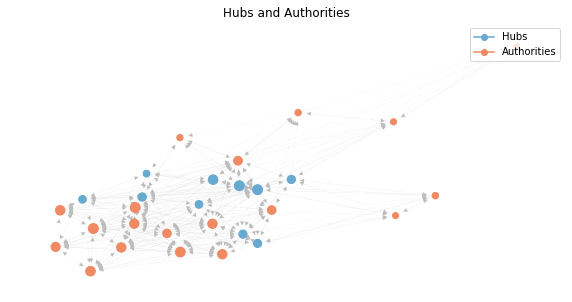

In [74]:
from matplotlib.lines import Line2D

G = load_seventh_graders()

hubs,authorities = nx.hits(G)

pos = nx.spring_layout(G)

plt.figure(figsize=(10, 5))

selectedHubs = {k:v for k,v in hubs.items() if v > authorities[k]}
authorities = {k:v for k,v in authorities.items() if v > hubs[k]}

max_hubs = max(hubs.values())
size = [v*100/max_hubs  for k, v in hubs.items()]
nodes = nx.draw_networkx_nodes(hubs, pos, node_size=size, node_color='#67a9cf')

max_authorities = max(authorities.values())
size = [v*100/max_authorities  for k, v in authorities.items()]
nodes = nx.draw_networkx_nodes(authorities, pos, node_size=size, node_color='#ef8a62')

edges = nx.draw_networkx_edges(G, pos, edge_color= "#bdbdbd", width =.05)

plt.title('Hubs and Authorities')
plt.axis('off')

line1 = Line2D(range(1), range(1), color="#67a9cf", marker='o')
line2 = Line2D(range(1), range(1), color="#ef8a62", marker='o')
plt.legend((line1,line2),('Hubs','Authorities'), numpoints=1, loc=1)

plt.show()

<h3>Community detection algorithms</h3>
<p>
A <b><a href="https://networkx.github.io/documentation/stable/reference/algorithms/clique.html">clique</a></b> is a complete (fully connected) subgraph, i.e. a set of vertices where each pair of vertices is connected (Cliques can overlap).<br>
A <b>maximal clique</b> is a clique that cannot be extended by including one more adjacent vertex (not included in larger one).
A <b>maximum clique</b> is a clique of the largest possible size in a given graph.
</p>
<p>
<b>Network communities</b> (cohesive subgroups) are groups of vertices such that vertices inside group connected with many more edges than beween groups.
A clique is a sort of ultimate community (maximum possible density) so the definition of a network community is a relaxation of the definition of a clique.<br>
<b>Community detection</b> is an assignment of vertices to communities (will consider non-overlapping communities: a node can belong to only one community).
<p>
We can use the <a href="https://networkx.github.io/documentation/stable/reference/generated/networkx.classes.function.density.html#networkx.classes.function.density"><b>density</b></a> measurement of a graph to see if the community found is correct.
<ol>
    <li> We measure the density of the whole graph (ρ) </li>
    <li> We measure the density of the edges outside the community (δext)</li>
    <li> Density is measured within the community (δint)</li>
</ol>    
If δint>ρ and δext<ρ then the community is correct.
</p>
<p>
The problem of identifying communities can be translated into the problem of finding the <b>optimal graph cuts</b>.<br>
By <a href="https://networkx.github.io/documentation/stable/reference/algorithms/cuts.html"><b>graph cut</b></a> we mean removing some edges in order to separate the graph into pieces. <br>
Measures can be defined to understand how many edges must be cut from the graph to identify the communities and evaluating the graph cuts (ratio cut, normalized cut, conductance).
</p>

<p>
<b><a href="https://en.wikipedia.org/wiki/Modularity_(networks)">Modularity</a></b> is one measure of the structure of networks or graphs. It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity is often used in optimization methods for detecting community structure in networks. It compare fraction of edges within the cluster to expected random graph with identical degree sequence.
The idea is if you split the graph into communities how much denser the part that is supposed to be a community compared to a random graph.
</p>

<p>
<b><a href="https://networkx.github.io/documentation/stable/reference/algorithms/community.html">Community detection algorithms</a></b> are greedy or heuristics algorithms and in general there are two approaches to finding communities: multiway partitioning (by looking at the graph you'are trying to cut out community areas) and recoursive partitioning.<br>
Some community detection algorithms are basically optimization algorithms of some measure (density, cut graph, modularity).
</p>

<p>Listed below are some community detection algorithms.<br>
<b>Edge betweenness algorithm (Newman-Girven, 2004):</b> greedy algorithm with a focus on edges that connect communities.<br>
<b>Spectral modularity partition (Newman, 2004) - Leading eigenvector:</b> algorithm with a focus on modularity maximization.<br>
<b>Label propagation algorithm (U.N. Raghavan, R. Albert, S. Kamura, 2007):</b> an heuristic algorithm.<br>
<b>Fast community unfolding algorithm:</b> heuristic method for greedy modularity optimization that follows the louvain method. This method is not based on the graph cut but starts with the nodes assigned to a certain cluster and
change the cluster of a node only if it increases modularity. This algorithm is currently one of the most used because it is very efficient and scalable. <br>
<b>Walktrap community:</b> it is about combining nodes together and not about cutting the graph and it is based on the concept on the random walk. The idea is that if a path starts from a node within a community, the path will remain there for a long time before going out
<p>
   

<h1>Example of large graph visualization</h1>

<a href="http://konect.uni-koblenz.de/networks/facebook-wosn-links"><h2>Facebook dataset</h2></a>
<p>This undirected network contains friendship data of Facebook users. A node represents a user and an edge represents a friendship between two users. The dataset is obviously not complete and contains a very small subset of the total Facebook friendship graph.</p>

In [80]:
G = load_facebook()
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2888
Number of edges: 2981
Average degree:   2.0644


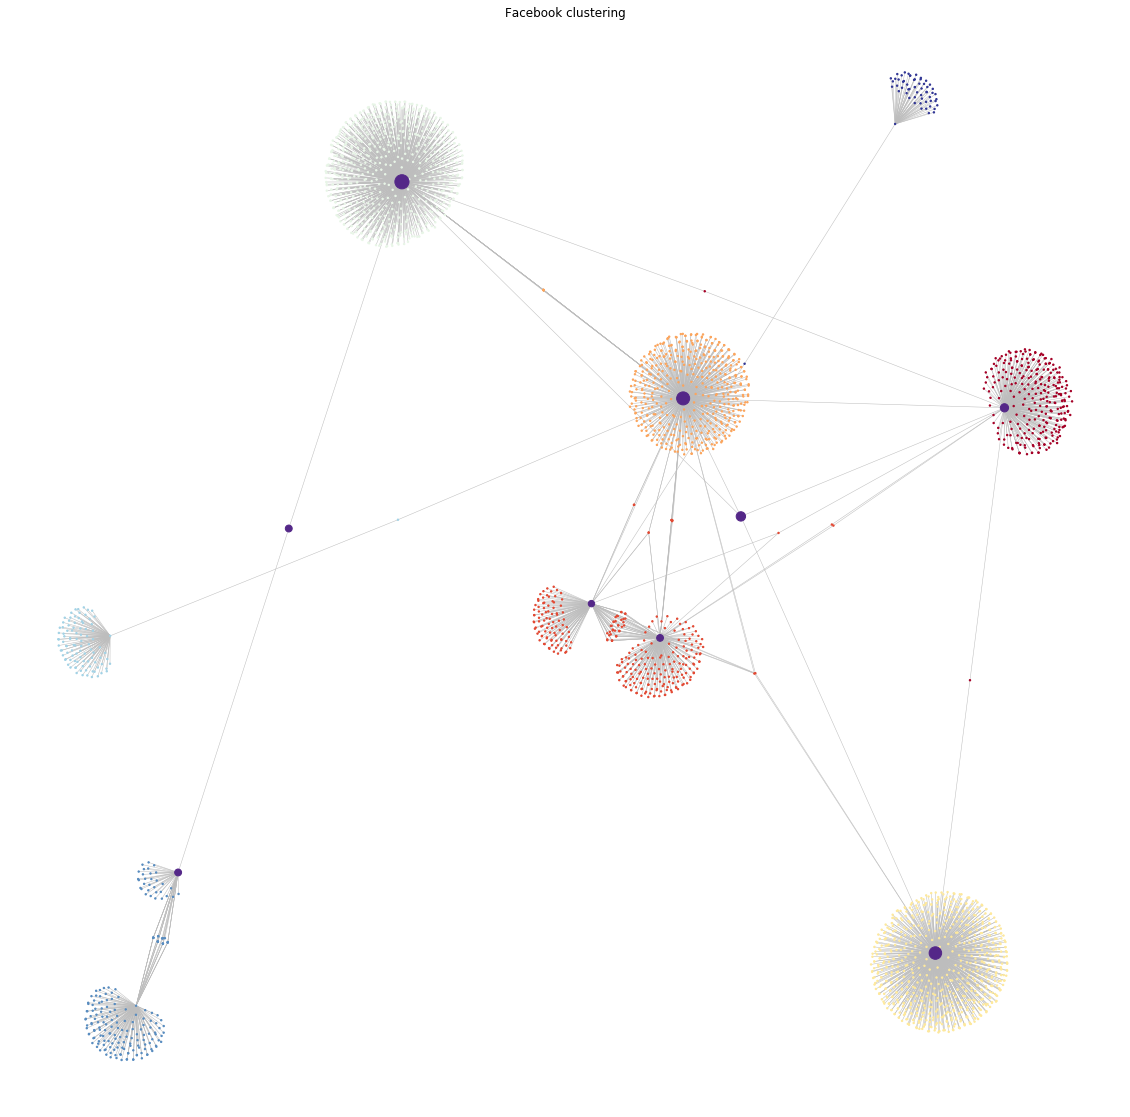

In [3]:
plt.figure(figsize=(20, 20))

pos = nx.spring_layout(G)

#louvain algorithm
partition = community.best_partition(G)
for n in G.nodes():
    G.nodes[n]['group'] =  partition[n]

cmap = pal.colorbrewer.diverging.RdYlBu_11.mpl_colormap
nodes = nx.draw_networkx_nodes(G, pos, node_size=2, cmap=cmap, 
                                   node_color=list(map(float,dict(G.nodes.data(data='group')).values())),
                                   nodelist=list(map(float,dict(G.nodes.data(data='group')).keys())))

edges = nx.draw_networkx_edges(G, pos, edge_color= "#bdbdbd", width =.5)

high_betweenness = {k: v for k, v in nx.betweenness_centrality(G, normalized=True).items() if v > 0.1}
pos_high_bet = {k: pos[k] for k, _ in high_betweenness.items()}
group_bet = {k: G.nodes(data=True)[k]['group'] for k, _ in high_betweenness.items()}
node_bet_size = [ v*200/max(high_betweenness.values()) for v in high_betweenness.values()]
nodes = nx.draw_networkx_nodes(high_betweenness, pos_high_bet, node_size=node_bet_size,
                                   node_color='#542788')

plt.title('Facebook clustering')
plt.axis('off')
plt.savefig('images/facebook.png', dpi=700)
plt.show()

<b><i>The hearth of a graph lies in its edges, not in its nodes</i></b><br>
<i>- John Quackenbush Harvard School of Public Health</i>